# Imports e Funções

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import joblib
# Filtrando o avisos
warnings.filterwarnings('ignore')

In [3]:
#Função de conexão com db
def conecta_db():
  con = psycopg2.connect(host='localhost', 
                         database='projeto',
                         user='postgres', 
                         password='admin')
  return con

#Função de consulta com db
def consultar_db(sql):
  con = conecta_db()
  cur = con.cursor()
  cur.execute(sql)
  recset = cur.fetchall()
  registros = []
  for rec in recset:
    registros.append(rec)
  con.close()
  return registros

#Função de cálculo de probabilidade
def calcular_probabilidades(df):
    categorias = ['historico', 'proposito', 'emprego', 'estadocivil', 'fiador', 'habitacao', 'profissao']
    numericas = ['duracao', 'valor']
    
    for coluna in categorias:
        probabilidades = df.groupby(coluna)['status'].apply(lambda x: (x == 0).mean())
        print(f"\nProbabilidades de inadimplência para a coluna '{coluna}':\n{probabilidades}")
    
    for coluna in numericas:
        mediana_valor = df[coluna].median()

        grupo_menor_igual = df[df[coluna] <= mediana_valor]
        grupo_maior = df[df[coluna] > mediana_valor]

        probabilidade_menor_igual = (grupo_menor_igual['status'] == 0).mean()
        probabilidade_maior = (grupo_maior['status'] == 0).mean()
        
        if coluna == 'duracao':
            print(f"\nProbabilidade de ser inadimplente para valores de {coluna} menores ou iguais à mediana: {probabilidade_menor_igual:.2f}")
            print(f"Probabilidade de ser inadimplente para valores de {coluna} maiores que a mediana: {probabilidade_maior:.2f}") 
        else:
            print(f"\nProbabilidade de ser inadimplente para valores de {coluna} menores ou iguais à mediana: {probabilidade_menor_igual:.2f}")
            print(f"Probabilidade de ser inadimplente para valores de {coluna} maiores que a mediana: {probabilidade_maior:.2f}")

## Consulta banco de dados e criação de dataframe

In [5]:
analise = consultar_db('select "Duracao", "HISTORICO", "PROPOSITO", "Valor", "INVESTIMENTOS", "EMPREGO", "TempoParcelamento", "ESTADOCIVIL","FIADOR","ResidenciaDesde", "Idade", "OUTROSFINANCIAMENTOS", "HABITACAO", "EmprestimoExistente", "PROFISSAO", "Dependentes", "SocioEmpresa","Estrangeiro", "Status" from "CREDITO" c inner join "HISTORICO_CREDITO" hc ON c."HistoricoCredito" = hc."IDHISTCRED" inner join "PROPOSITO" p on c."Proposito" = p."IDPROPOSITO" inner join "INVESTIMENTOS" i on c."Investimentos" = i."IDINVESTIMENTOS" inner join "EMPREGO" e on c."Emprego" = e."IDEMPREGO" inner join "ESTADOCIVIL" ec on c."EstadoCivil" = ec."IDESTADOCIVIL" inner join "FIADOR" ft on c."FiadorTerceiros" = ft."IDFIADOR" inner join "OUTROSFINANC" of on c."OutrosFinanciamentos" = of."IDOUTROSFINANC" inner join "HABITACAO" h on c."Habitacao" = h."IDHABITACAO" inner join "PROFISSAO" pr on c."Profissao" = pr."IDPROFISSAO" ')
analise = pd.DataFrame(analise, columns=["duracao", "historico", "proposito", "valor", "investimentos", "emprego", "tempoparcelamento", "estadocivil","fiador","residenciadesde", "idade", "outrosfinanciamentos", "habitacao", "emprestimoexistente", "profissao", "dependentes", "socioempresa","estrangeiro", "status"])
#analise

# Descrição das colunas

| Coluna                  | Descrição                                                                                  |
|-------------------------|--------------------------------------------------------------------------------------------|
| duracao                 | Duração do empréstimo em meses                                                             |
| historico               | Histórico de crédito do cliente                                                            |
| proposito               | Propósito do empréstimo                                                                    |
| valor                   | Valor do empréstimo                                                                        |
| investimentos           | Investimentos do cliente (e.g., <100, >=1000)                                              |
| emprego                 | Tempo de emprego do cliente (e.g., 1<=X<4, >=7)                                            |
| tempoparcelamento       | Tempo do parcelamento em anos                                                              |
| estadocivil             | Estado civil do cliente                                                                    |
| fiador                  | Se o cliente tem um fiador (sim/não)                                                       |
| residenciadesde         | Tempo que o cliente reside no endereço atual (em anos)                                     |
| idade                   | Idade do cliente                                                                           |
| outrosfinanciamentos    | Se o cliente tem outros financiamentos (e.g., nenhum)                                      |
| habitacao               | Situação da habitação do cliente (e.g., própria, alugada, de graça)                        |
| emprestimoexistente     | Quantidade de empréstimos existentes                                                       |
| profissao               | Profissão do cliente (e.g., qualificado, não qualificado)                                  |
| dependentes             | Número de dependentes do cliente                                                           |
| socioempresa            | Se o cliente é sócio de uma empresa (sim/não)                                              |
| estrangeiro             | Se o cliente é estrangeiro (sim/não)                                                       |
| status                  | Status do empréstimo (variável alvo) (e.g., 0, 1)                                          |


# Análise Exploratória de Dados

In [9]:
# Mostrar as primeiras linhas do DataFrame
print("Primeiras linhas do arquivo:")
print(analise.head())

# Mostrar informações básicas sobre o DataFrame
print("\nInformações básicas:")
print(analise.info())

# Mostrar estatísticas descritivas para colunas numéricas
print("\nEstatísticas descritivas (colunas numéricas):")
print(analise.describe())

# Mostrar estatísticas descritivas para colunas categóricas
print("\nEstatísticas descritivas (colunas categóricas):")
print(analise.describe(include=['O']))


Primeiras linhas do arquivo:
   duracao                historico     proposito  valor   investimentos  \
0       48         existentes/pagos       reforma   5951          <100\n   
1       12  Critico-outros creditos      educacao   2096          <100\n   
2       42         existentes/pagos        moveis   7882          <100\n   
3       24       Atrasos anteriores  veiculo novo   4870          <100\n   
4       36         existentes/pagos      educacao   9055  Desconhecido\n   

  emprego  tempoparcelamento           estadocivil fiador  residenciadesde  \
0  1<=X<4                  2  feminino div/dep/cas    nao              2.0   
1  4<=X<7                  2    masculino solteiro    nao              3.0   
2  4<=X<7                  2    masculino solteiro    sim              4.0   
3  1<=X<4                  3    masculino solteiro    nao              4.0   
4  1<=X<4                  2    masculino solteiro    nao              4.0   

   idade outrosfinanciamentos habitacao  empr

## Tratamento de Dados

In [11]:
# Verificando a presença de valores nulos
print("\nValores nulos por coluna:")
print(analise.isnull().sum())

# Verificando a presença de valores duplicados
print("\nQuantidade de valores duplicados:")
print(analise.duplicated().sum())



Valores nulos por coluna:
duracao                 0
historico               0
proposito               0
valor                   0
investimentos           0
emprego                 0
tempoparcelamento       0
estadocivil             0
fiador                  0
residenciadesde         6
idade                   0
outrosfinanciamentos    0
habitacao               0
emprestimoexistente     0
profissao               0
dependentes             0
socioempresa            0
estrangeiro             0
status                  0
dtype: int64

Quantidade de valores duplicados:
0


In [12]:
# Calculando a moda da coluna 'residenciadesde' para substituir valor nul
moda_residencia = analise['residenciadesde'].mode()[0]

# Preenchendo os valores nulos com a moda
analise['residenciadesde'] = analise['residenciadesde'].fillna(moda_residencia)

# Verificando se não há mais valores nulos na coluna
print("Valores nulos em 'residenciadesde' após preenchimento:")
print(analise['residenciadesde'].isnull().sum())

Valores nulos em 'residenciadesde' após preenchimento:
0


* Estatísticas Descritivas das Colunas Numéricas

    As estatísticas descritivas incluem contagem (count), média (mean), desvio padrão (std), valor mínimo (min), percentis (25%, 50%, 75%) e valor máximo (max).

        duracao: A duração média dos empréstimos é de aproximadamente 20,8 meses, com um desvio padrão de 12,08 meses e com variação de 4 a 72 meses. A maioria dos empréstimos tem durações entre 12 e 24 meses (25% e 75% percentis).
        valor: O valor médio dos empréstimos é de 3259,82, com um desvio padrão de 2809,69, mas há uma grande variação (desvio padrão de 2809,69), indicando a presença de empréstimos de diferentes tamanhos. Os valores dos empréstimos variam de 250 a 18424, com a maioria concentrada entre 1372,5 e 3956,5 (25% e 75% percentis).
        tempoparcelamento: O tempo médio de parcelamento é de aproximadamente 2,96 meses, indicando que os clientes costumam parcelar seus empréstimos em poucas prestações.
        residenciadesde: Os clientes residem em média 2,84 anos no mesmo endereço, com pouca variação.
        idade: A idade média dos clientes é de 35,52 anos, com um desvio padrão de 11,37, indicando uma ampla faixa etária. A maioria dos clientes tem entre 27 e 42 anos (25% e 75% percentis).
        emprestimoexistente: A maioria dos clientes tem cerca de 1 a 2 empréstimos existentes, com um máximo de 4.
        dependentes: O número médio de dependentes é de 1,16.
        socioempresa: Aproximadamente 40% dos clientes são sócios de empresas.
        estrangeiro: Apenas cerca de 3,7% dos clientes são estrangeiros.
        status: Cerca de 69,6% dos empréstimos estão no status "1". Isso indica que a maioria dos clientes consegue pagar seus empréstimos, mas há uma parcela significativa de inadimplência.

* Estatísticas Descritivas das Colunas Categóricas

        historico: A maioria dos clientes tem um histórico de "existentes/pagos", o que pode indicar que muitos clientes têm um bom histórico de crédito.
        proposito: O propósito mais comum dos empréstimos é "reforma", seguido por outros propósitos como "educação" e "veículo novo".
        investimentos: A maioria dos clientes tem investimentos abaixo de 100.
        emprego: A maioria dos clientes tem entre 1 a 4 anos de emprego, o que pode indicar estabilidade moderada no emprego.
        estadocivil: A maioria dos clientes são homens solteiros.
        fiador: A maioria dos clientes não possui fiador.
        outrosfinanciamentos: A maioria dos clientes não possui outros financiamentos, o que pode indicar menor risco financeiro.
        habitacao: A maioria dos clientes possui a própria casa, o que pode ser um indicador de estabilidade financeira.
        profissao: A profissão mais comum é "qualificado", o que pode indicar um nível educacional ou profissional mais elevado entre os clientes.

* Valores Nulos

        A única coluna com valores nulos é residenciadesde, com 6 valores ausentes.

* Valores Duplicados

        Não há valores duplicados no dataset.

## Hipóteses

1. Duração do Empréstimo:

        Hipótese: Empréstimos com maior duração estão mais propensos a inadimplência.
        Nível de Relevância: Alta

2. Valor do Empréstimo:

        Hipótese: Empréstimos de maior valor têm maior chance de inadimplência.
        Nível de Relevância: Alta
        
3. Histórico de Crédito:

        Hipótese: Solicitantes com histórico de crédito ruim têm maior probabilidade de inadimplência.
        Nível de Relevância: Alta

4. Propósito do Empréstimo:

        Hipótese: Empréstimos para fins de reforma têm maior probabilidade de inadimplência.
        Nível de Relevância: Média

5. Emprego:

        Hipótese: Solicitantes com menor estabilidade no emprego têm maior probabilidade de inadimplência.
        Nível de Relevância: Média

6. Estado Civil:

        Hipótese: Solicitantes solteiros do sexo masculino têm maior probabilidade de inadimplência.
        Nível de Relevância: Média

7. Fiador:

        Hipótese: Solicitantes sem fiador têm maior probabilidade de inadimplência.
        Nível de Relevância: Alta

8. Habitação:

        Hipótese: Solicitantes com habitação própria têm menor probabilidade de inadimplência.
        Nível de Relevância: Alta

9. Profissão:

        Hipótese: Solicitantes com profissão altamente qualificada têm menor probabilidade de inadimplência.
        Nível de Relevância: Alta


## Probabilidades

In [17]:
# Chamando a função para calcular e imprimir as probabilidades
calcular_probabilidades(analise)


Probabilidades de inadimplência para a coluna 'historico':
historico
Atrasos anteriores          0.337349
Critico-outros creditos     0.168421
existentes/pagos            0.322896
sem creditos/todos pagos    0.625000
todos pagos                 0.595745
Name: status, dtype: float64

Probabilidades de inadimplência para a coluna 'proposito':
proposito
abrir negocio    0.351064
educacao         0.437500
moveis           0.331429
outros           0.416667
qualificacao     0.125000
quitar divida    0.333333
reforma          0.229630
reforma casa     0.363636
veiculo novo     0.377193
veiculo usado    0.164948
Name: status, dtype: float64

Probabilidades de inadimplência para a coluna 'emprego':
emprego
1<=X<4          0.310241
4<=X<7          0.237805
<1              0.401198
>=7             0.258197
Desempregado    0.372881
Name: status, dtype: float64

Probabilidades de inadimplência para a coluna 'estadocivil':
estadocivil
feminino div/dep/cas    0.352159
maculino div/dep        0.4000

# Visualização de Dados

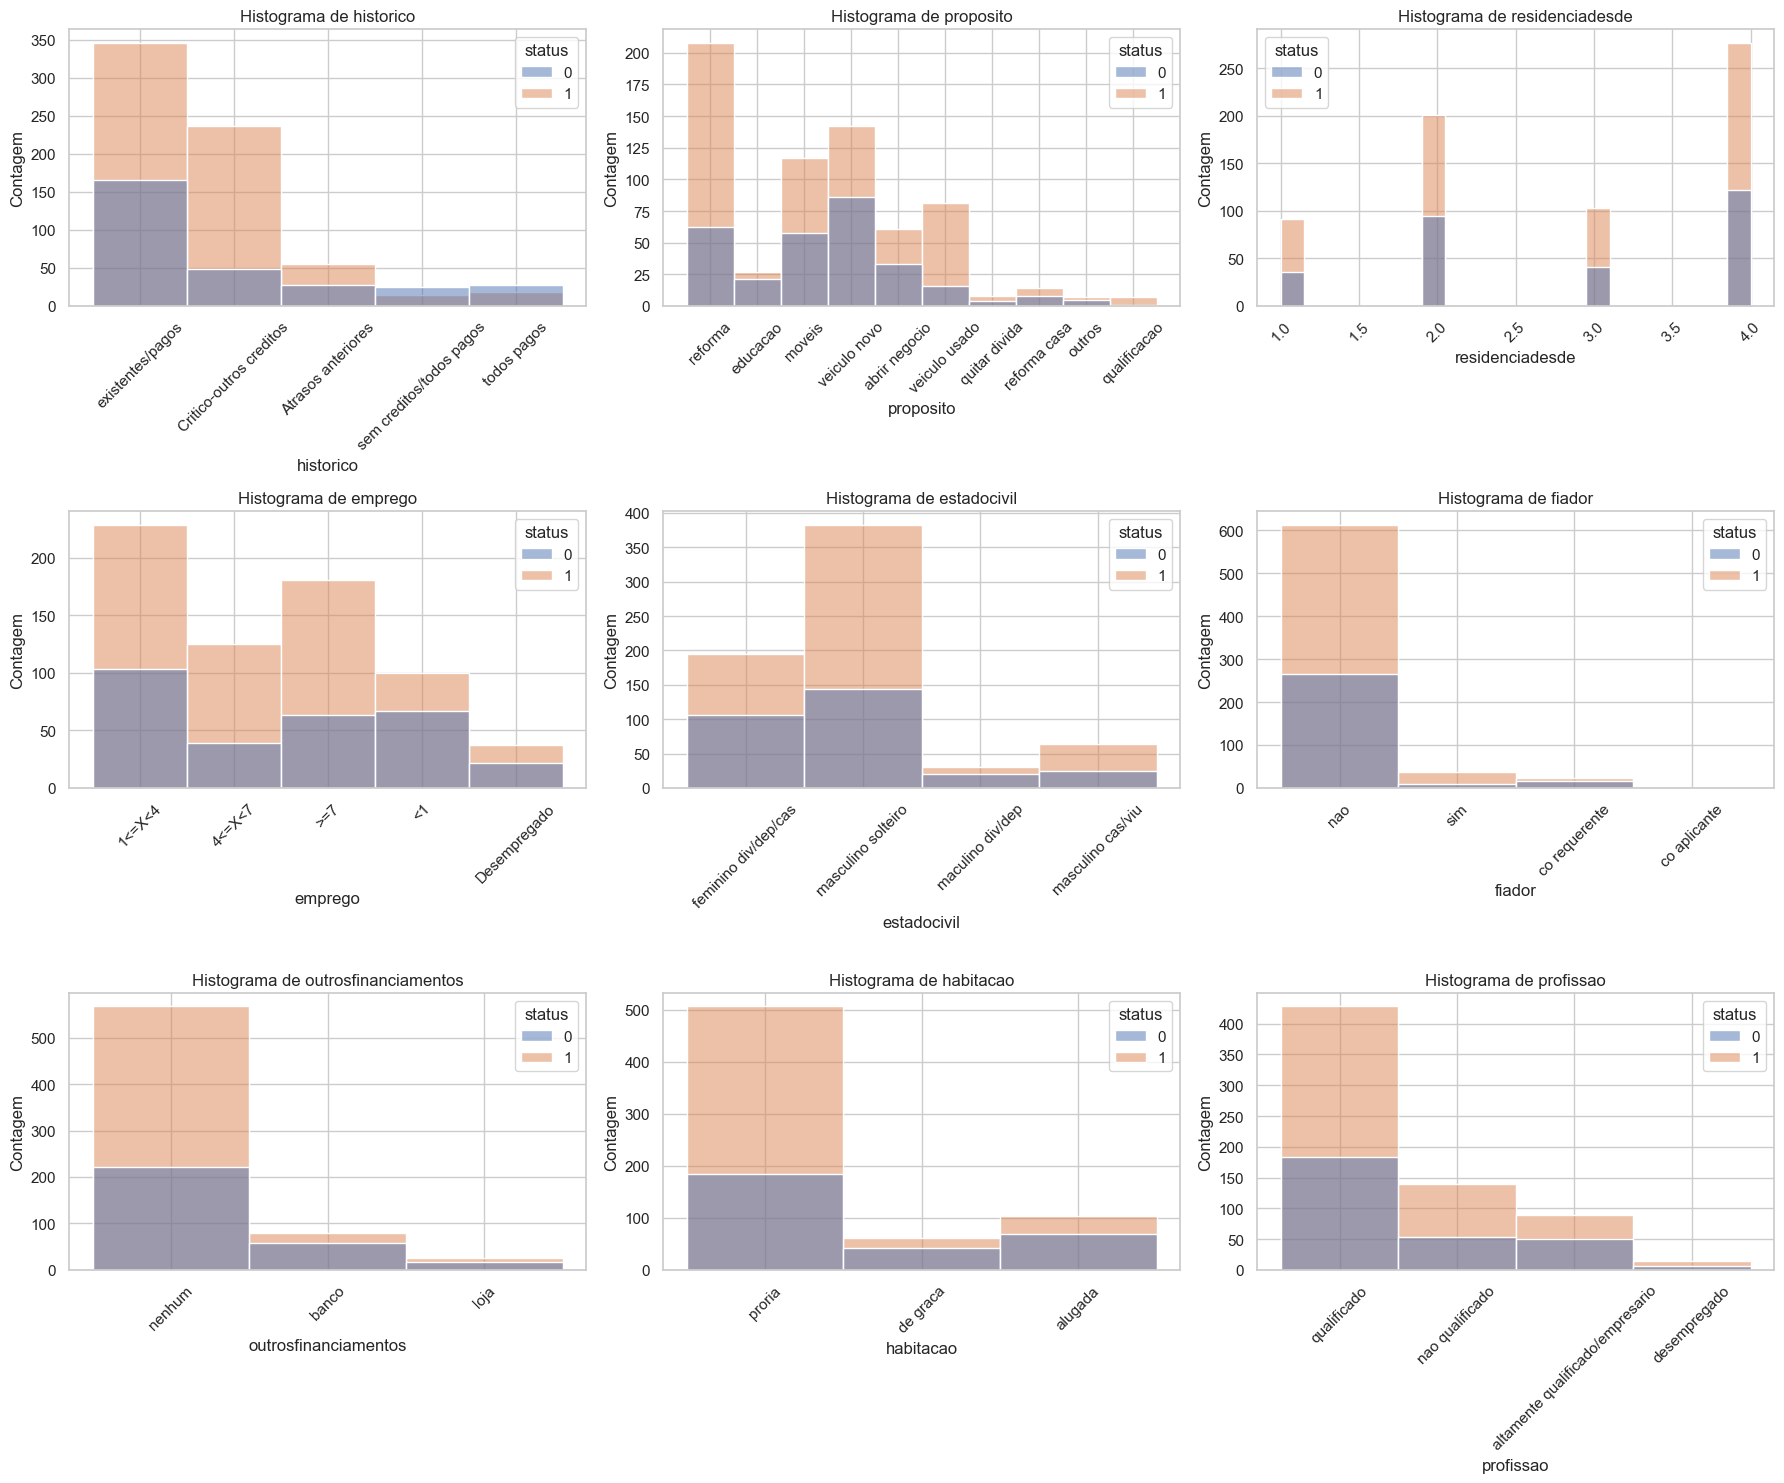

In [19]:
# Definindo o estilo dos gráficos
sns.set(style="whitegrid")

# Criando subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

# Histograma das variáveis categóricas
cat_cols = ['historico', 'proposito', 'residenciadesde', 'emprego', 'estadocivil', 'fiador', 'outrosfinanciamentos',
            'habitacao', 'profissao']

sns.histplot(x='historico', data=analise, hue='status',bins=20, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title(f'Histograma de {cat_cols[0]}')
axs[0, 0].set_xlabel(cat_cols[0])
axs[0, 0].set_ylabel('Contagem')
axs[0, 0].tick_params(axis='x', rotation=45)  # Rotacionando o texto do eixo x

sns.histplot(x='proposito', data=analise, hue='status', bins=20, color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title(f'Histograma de {cat_cols[1]}')
axs[0, 1].set_xlabel(cat_cols[1])
axs[0, 1].set_ylabel('Contagem')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.histplot(x='residenciadesde', data=analise, hue='status', bins=20, color='skyblue', ax=axs[0, 2])
axs[0, 2].set_title(f'Histograma de {cat_cols[2]}')
axs[0, 2].set_xlabel(cat_cols[2])
axs[0, 2].set_ylabel('Contagem')
axs[0, 2].tick_params(axis='x', rotation=45)

sns.histplot(x='emprego', data=analise, hue='status', bins=20, color='skyblue', ax=axs[1, 0])
axs[1, 0].set_title(f'Histograma de {cat_cols[3]}')
axs[1, 0].set_xlabel(cat_cols[3])
axs[1, 0].set_ylabel('Contagem')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.histplot(x='estadocivil', data=analise, hue='status', bins=20, color='skyblue', ax=axs[1, 1])
axs[1, 1].set_title(f'Histograma de {cat_cols[4]}')
axs[1, 1].set_xlabel(cat_cols[4])
axs[1, 1].set_ylabel('Contagem')
axs[1, 1].tick_params(axis='x', rotation=45)

sns.histplot(x='fiador', data=analise, hue='status', bins=20, color='skyblue', ax=axs[1, 2])
axs[1, 2].set_title(f'Histograma de {cat_cols[5]}')
axs[1, 2].set_xlabel(cat_cols[5])
axs[1, 2].set_ylabel('Contagem')
axs[1, 2].tick_params(axis='x', rotation=45)

sns.histplot(x='outrosfinanciamentos', data=analise, hue='status', bins=20, color='skyblue', ax=axs[2, 0])
axs[2, 0].set_title(f'Histograma de {cat_cols[6]}')
axs[2, 0].set_xlabel(cat_cols[6])
axs[2, 0].set_ylabel('Contagem')
axs[2, 0].tick_params(axis='x', rotation=45)

sns.histplot(x='habitacao', data=analise, hue='status', bins=20, color='skyblue', ax=axs[2, 1])
axs[2, 1].set_title(f'Histograma de {cat_cols[7]}')
axs[2, 1].set_xlabel(cat_cols[7])
axs[2, 1].set_ylabel('Contagem')
axs[2, 1].tick_params(axis='x', rotation=45)

sns.histplot(x='profissao', data=analise, hue='status', bins=20, color='skyblue', ax=axs[2, 2])
axs[2, 2].set_title(f'Histograma de {cat_cols[8]}')
axs[2, 2].set_xlabel(cat_cols[8])
axs[2, 2].set_ylabel('Contagem')
axs[2, 2].tick_params(axis='x', rotation=45)

# Ajustando o layout
plt.tight_layout()
plt.show()

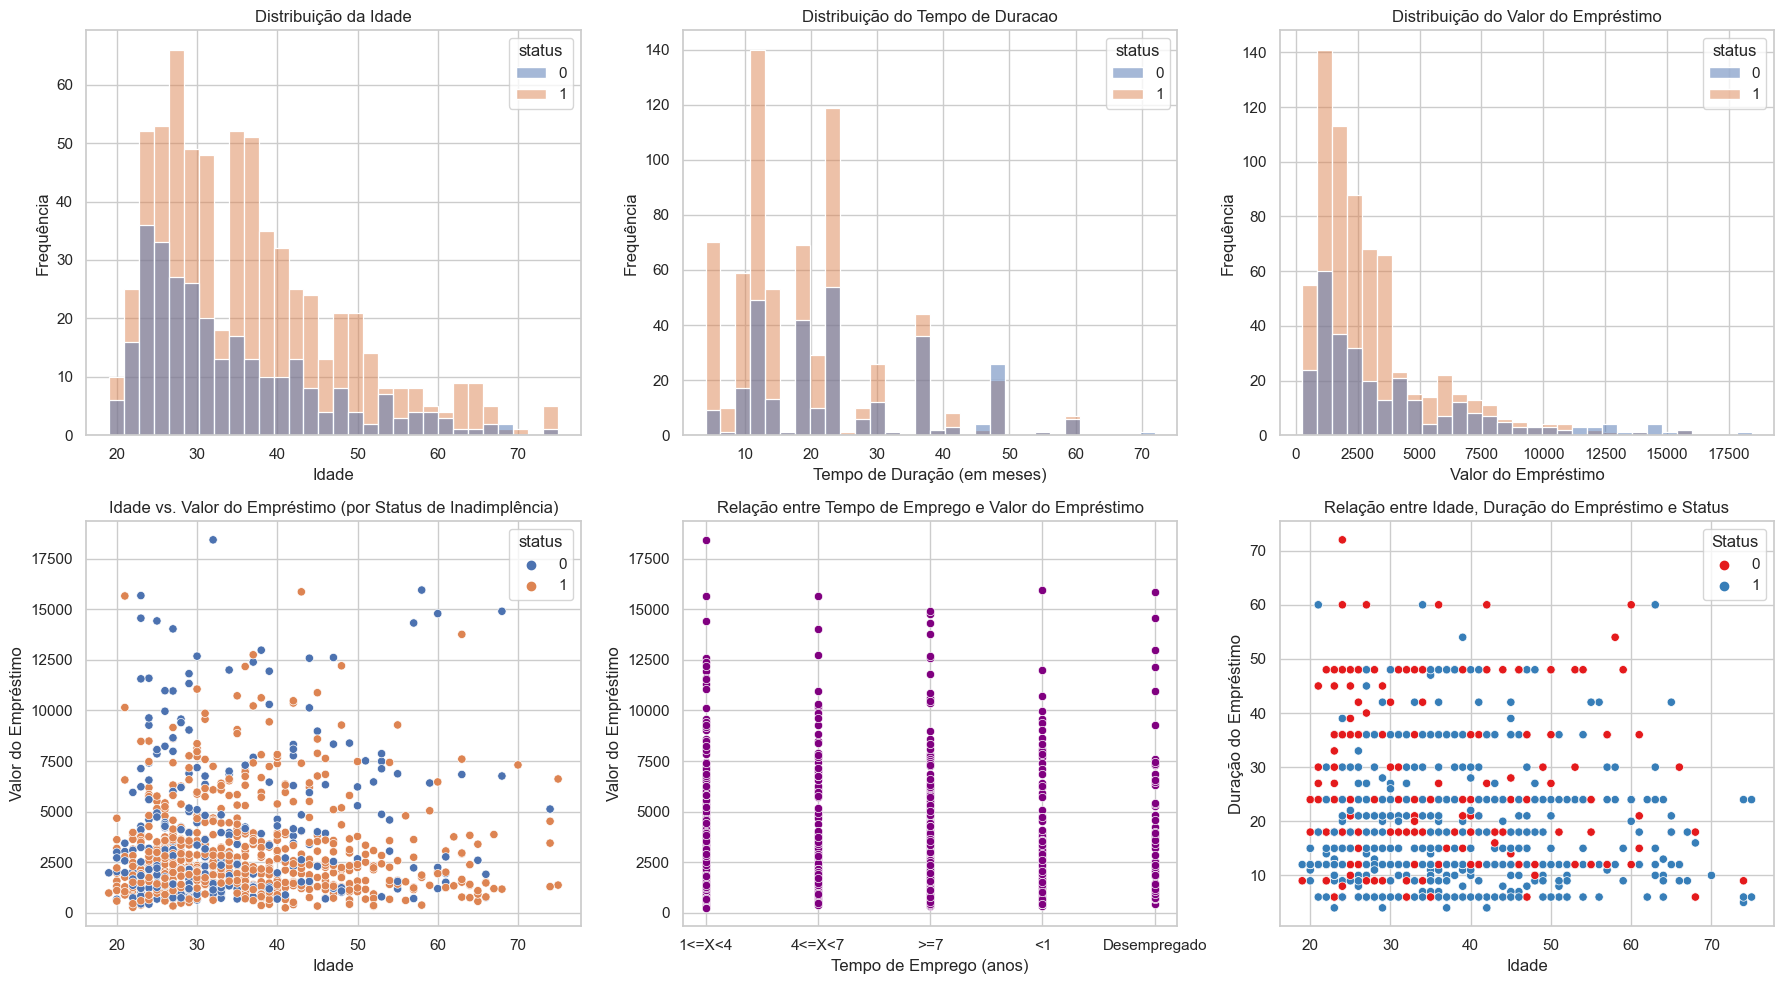

In [20]:
# Definindo o estilo dos gráficos
sns.set(style="whitegrid")

# Criando subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribuição da idade
sns.histplot(x='idade', data=analise, hue='status', bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribuição da Idade')
axes[0, 0].set_xlabel('Idade')
axes[0, 0].set_ylabel('Frequência')

# Distribuição do tempo de duraca
sns.histplot(x='duracao', data=analise, hue='status', bins=30, color='salmon', ax=axes[0, 1])
axes[0, 1].set_title('Distribuição do Tempo de Duracao')
axes[0, 1].set_xlabel('Tempo de Duração (em meses)')
axes[0, 1].set_ylabel('Frequência')

# Distribuição do valor do empréstimo
sns.histplot(x='valor', data=analise, hue='status', bins=30, color='lightgreen', ax=axes[0, 2])
axes[0, 2].set_title('Distribuição do Valor do Empréstimo')
axes[0, 2].set_xlabel('Valor do Empréstimo')
axes[0, 2].set_ylabel('Frequência')

# Scatter plot de idade vs. valor_emprestimo
sns.scatterplot(x='idade', y='valor', data=analise, hue='status', ax=axes[1, 0])
axes[1, 0].set_title('Idade vs. Valor do Empréstimo (por Status de Inadimplência)')
axes[1, 0].set_xlabel('Idade')
axes[1, 0].set_ylabel('Valor do Empréstimo')

# Relação entre tempo de emprego e valor do empréstimo
sns.scatterplot(x='emprego', y='valor', data=analise, color='purple', ax=axes[1, 1])
axes[1, 1].set_title('Relação entre Tempo de Emprego e Valor do Empréstimo')
axes[1, 1].set_xlabel('Tempo de Emprego (anos)')
axes[1, 1].set_ylabel('Valor do Empréstimo')

# Relação entre Idade, Duração do Empréstimo e Status
sns.scatterplot(x='idade', y='duracao', data=analise, hue='status', palette='Set1', ax=axes[1, 2])
axes[1, 2].set_title('Relação entre Idade, Duração do Empréstimo e Status')
axes[1, 2].set_xlabel('Idade')
axes[1, 2].set_ylabel('Duração do Empréstimo')
axes[1, 2].legend(title='Status', loc='upper right')

# Ajustando layout
plt.tight_layout()

# Exibindo os gráficos
plt.show()


## Hipóteses após análise dos gráficos e cáculo de probabilidades

1. Duração do Empréstimo:

        Conclusão: Verdadeira
        Nível de Relevância: Alta

2. Valor do Empréstimo:

        Conclusão: Verdadeira
        Nível de Relevância: Alta
        
3. Histórico de Crédito:

        Conclusão: Verdadeira
        Nível de Relevância: Alta

4. Propósito do Empréstimo:

        Conclusão: Falsa
        Nível de Relevância: Média

5. Emprego:

        Conclusão: Verdadeira
        Nível de Relevância: Média

6. Estado Civil:

        Conclusão: Falsa
        Nível de Relevância: Média

7. Fiador:

        Conclusão: Falsa
        Nível de Relevância: Alta

8. Habitação:

        Conclusão: Verdadeira
        Nível de Relevância: Alta

9. Profissão:

        Conclusão: Falsa
        Nível de Relevância: Alta


# Aprendizado de Máquina

## Pré-Processamento de Dados

In [25]:
#Criando cópia para preservar df original
modelo=analise.copy()

# Colunas categóricas
categorical_columns = modelo.select_dtypes(include=['O']).columns

# Inicializando OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Aplicando OneHotEncoder e transformar as colunas categóricas
encoded_features = one_hot_encoder.fit_transform(modelo[categorical_columns])

# Obtendo nomes das novas colunas criadas pelo OneHotEncoder
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

# Criando DataFrame com as novas colunas
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenando o DataFrame original (sem as colunas categóricas) com o DataFrame das novas colunas
modelo = pd.concat([modelo.drop(columns=categorical_columns), encoded_df], axis=1)

# Exibir DataFrame transformado
#modelo

## Padronização

In [27]:
# Separar features e target
X = modelo.drop('status', axis=1)
y = modelo['status']

# Aplicar RobustScaler
scaler = RobustScaler()

# Selecionando apenas as colunas numéricas para a padronização
numeric_columns = X.select_dtypes(include=['number']).columns

# Aplicando a padronização às colunas numéricas
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
#X

## Balanceamento

In [29]:
# Random Oversampler
ros = RandomOverSampler(random_state = 33)
X, y = ros.fit_resample(X, y)

## Separação treino e teste

In [31]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42, stratify=y)


## Algoritmo

O algoritmo Random Forest parece ser a escolha mais equilibrada, com bons resultados em todas as métricas e uma abordagem relativamente simples.

In [34]:
# Criação e treinamento do Modelo
clf = RandomForestClassifier(
    bootstrap= False, 
    max_features= 'log2', 
    random_state=42).fit(X_train, y_train)

# Predição
y_pred = clf.predict(X_test)

# Avaliação do desempenho do modelo
print("\nRelatório de Classificação:")
print(f"\n {classification_report(y_test, y_pred)} ")


Relatório de Classificação:

               precision    recall  f1-score   support

           0       0.89      0.90      0.89       189
           1       0.90      0.89      0.89       188

    accuracy                           0.89       377
   macro avg       0.89      0.89      0.89       377
weighted avg       0.89      0.89      0.89       377
 


## Atributos mais importantes

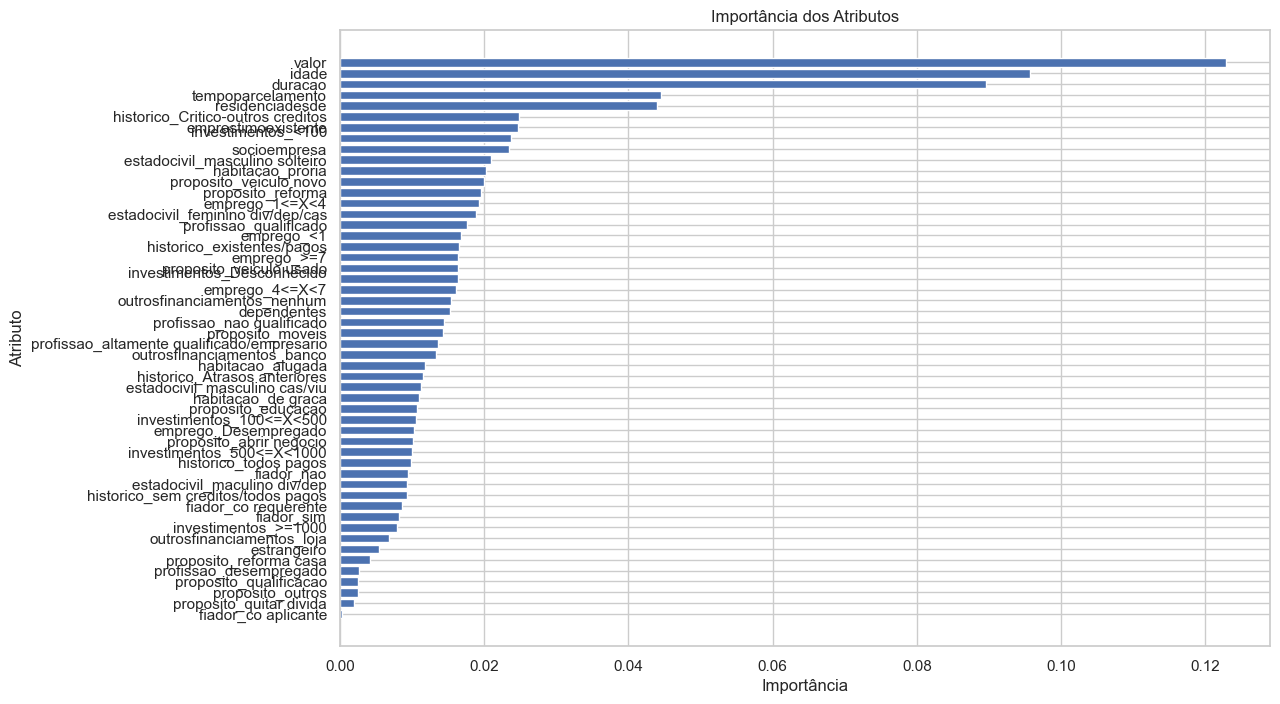

In [36]:
# Importância dos atributos
importances = clf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Ordenar por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotar a importância dos atributos
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.title('Importância dos Atributos')
plt.gca().invert_yaxis()
plt.show()



## Salvando Modelo

In [37]:
# Salvando o modelo
#joblib_file = "random_forest_model.pkl"
#joblib.dump(clf, joblib_file)

In [38]:
# Carregando o modelo salvo
model = joblib.load("random_forest_model.pkl")

In [41]:
# Fazendo previsões
previsoes = model.predict(X_test.head(1))

print("Previsões para os novos dados:")
print(previsoes)

Previsões para os novos dados:
[1]
